In [57]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19
from PIL import Image
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import random
import torch.nn.functional as F
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
import time
import glob
import imageio.v2 as imageio
import matplotlib.image as mpimg

In [27]:
def set_seed(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multiple GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [28]:
import numpy as np
from tensorflow.keras.datasets import mnist

def load_mnist():

    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Normalize images to [0, 1]
    train_images = train_images.astype('float32') / 255.0
    test_images = test_images.astype('float32') / 255.0

    # Set alias variables to match previous format
    X_train = train_images
    Y_train = train_labels
    X_test = test_images
    Y_test = test_labels

    return X_train, Y_train, X_test, Y_test


In [29]:
# Load MNIST data
print("Loading the Dataset...")
start_time = time.time()
X_train_images, Y_train, X_test_images, Y_test = load_mnist()
load_time = time.time() - start_time
print(f"Dataset Loaded in {load_time:.2f} seconds!")

Loading the Dataset...
Dataset Loaded in 0.41 seconds!


In [30]:
class MultiscalePatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, embed_dim_large=384, embed_dim_small=192, patch_size_large=7, patch_size_small=3):
        super(MultiscalePatchEmbedding, self).__init__()
        self.proj_large = nn.Conv2d(in_channels, embed_dim_large, kernel_size=patch_size_large, stride=patch_size_large)
        self.proj_small = nn.Conv2d(in_channels, embed_dim_small, kernel_size=patch_size_small, stride=patch_size_small)

    def forward(self, x):
        x_large = self.proj_large(x).flatten(2).transpose(1, 2)
        x_small = self.proj_small(x).flatten(2).transpose(1, 2)
        return x_large, x_small

In [31]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        x = x + attn_output
        x = self.norm1(x)
        x = x + self.mlp(x)
        x = self.norm2(x)
        return x

In [32]:
class MultiscaleViTEncoder(nn.Module):
    def __init__(self, embed_dim_large, embed_dim_small, num_heads_large, num_heads_small, num_layers):
        super(MultiscaleViTEncoder, self).__init__()
        self.encoder_large = nn.ModuleList([TransformerEncoderBlock(embed_dim_large, num_heads_large, embed_dim_large * 4) for _ in range(num_layers)])
        self.encoder_small = nn.ModuleList([TransformerEncoderBlock(embed_dim_small, num_heads_small, embed_dim_small * 4) for _ in range(num_layers)])

    def forward(self, x_large, x_small):
        for layer in self.encoder_large:
            x_large = layer(x_large)
        for layer in self.encoder_small:
            x_small = layer(x_small)
        return x_large, x_small

In [33]:
class MergeMultiscale(nn.Module):
    def __init__(self, embed_dim_large=384, embed_dim_small=192, merged_dim=512):
        super(MergeMultiscale, self).__init__()
        self.fc_large = nn.Linear(embed_dim_large, merged_dim)
        self.fc_small = nn.Linear(embed_dim_small, merged_dim)

    def forward(self, x_large, x_small, num_patches_small):
        x_large = self.fc_large(x_large)
        x_small = self.fc_small(x_small)
        target_size = int(num_patches_small ** 0.5)
        grid_large_size = int(x_large.size(1) ** 0.5)
        x_large = F.interpolate(
            x_large.transpose(1, 2).reshape(-1, x_large.size(2), grid_large_size, grid_large_size),
            size=(target_size, target_size),
            mode="bilinear",
            align_corners=True
        ).flatten(2).transpose(1, 2)
        x = torch.cat([x_large, x_small], dim=1)
        return x

In [34]:
class PixelShuffleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor=2):
        super(PixelShuffleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.relu(x)
        return x

In [35]:
class Decoder(nn.Module):
    def __init__(self, merged_dim=512, out_channels=1, upscale_factor=2):
        super(Decoder, self).__init__()
        self.upscale_factor = upscale_factor
        self.initial_conv = nn.Conv2d(merged_dim, 256, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle_blocks = nn.Sequential(
            PixelShuffleBlock(256, 128),
            PixelShuffleBlock(128, 64),
        )
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x, H, W):
        batch_size, num_patches, embed_dim = x.size()
        grid_height = int(np.ceil(np.sqrt(num_patches)))
        grid_width = int(np.ceil(num_patches / grid_height))
        padding_patches = grid_height * grid_width - num_patches
        if padding_patches > 0:
            pad = torch.zeros(batch_size, padding_patches, embed_dim, device=x.device)
            x = torch.cat([x, pad], dim=1)
        x = x.transpose(1, 2).reshape(batch_size, embed_dim, grid_height, grid_width)
        x = self.initial_conv(x)
        x = self.pixel_shuffle_blocks(x)
        x = self.final_conv(x)
        x = F.interpolate(
            x,
            size=(H * self.upscale_factor, W * self.upscale_factor),
            mode="bilinear",
            align_corners=True
        )  # Upscale by the factor
        return x

In [36]:
class EdgeLoss(nn.Module):
    def forward(self, sr, hr):
        sr_diff_x = torch.abs(torch.diff(sr, dim=2))
        sr_diff_y = torch.abs(torch.diff(sr, dim=3))
        hr_diff_x = torch.abs(torch.diff(hr, dim=2))
        hr_diff_y = torch.abs(torch.diff(hr, dim=3))

        sr_diff_x = nn.functional.pad(sr_diff_x, (0, 0, 1, 0))
        sr_diff_y = nn.functional.pad(sr_diff_y, (1, 0, 0, 0))
        hr_diff_x = nn.functional.pad(hr_diff_x, (0, 0, 1, 0))
        hr_diff_y = nn.functional.pad(hr_diff_y, (1, 0, 0, 0))

        sr_edge = sr_diff_x + sr_diff_y
        hr_edge = hr_diff_x + hr_diff_y

        return torch.mean((sr_edge - hr_edge) ** 2)

In [37]:
class GrayscaleMultiscaleViTSuperResolution(nn.Module):
    def __init__(self, embed_dim_large, embed_dim_small, patch_size_large, patch_size_small, upscale_factor=2):
        super(GrayscaleMultiscaleViTSuperResolution, self).__init__()
        self.patch_embed = MultiscalePatchEmbedding(1, embed_dim_large, embed_dim_small, patch_size_large, patch_size_small)
        self.encoder = MultiscaleViTEncoder(embed_dim_large, embed_dim_small, 4, 2, 4)  # Reduced heads and layers
        self.merge = MergeMultiscale(embed_dim_large, embed_dim_small, 512)  # Reduced merged dim
        self.decoder = Decoder(512, 1, upscale_factor)  # 1 output channel for grayscale

    def forward(self, x):
        H, W = x.shape[2], x.shape[3]
        x_large, x_small = self.patch_embed(x)
        x_large, x_small = self.encoder(x_large, x_small)
        x = self.merge(x_large, x_small, x_small.size(1))
        x = self.decoder(x, H, W)
        return x

In [38]:
class MNISTSuperResolutionDataset(Dataset):
    def __init__(self, images, transform=None, augment=False):
        self.images = images  # Original 28x28 images
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get original 28x28 image
        hr_image = self.images[idx].reshape(28, 28)

        # Convert to PIL for resize operations
        hr_image_pil = Image.fromarray((hr_image * 255).astype(np.uint8))

        # Create low-resolution 14x14 image
        lr_image_pil = hr_image_pil.resize((14, 14), Image.BILINEAR)

        # Convert back to tensor
        if self.transform:
            hr_image = self.transform(hr_image_pil)
            lr_image = self.transform(lr_image_pil)
        else:
            hr_image = transforms.ToTensor()(hr_image_pil)
            lr_image = transforms.ToTensor()(lr_image_pil)

        # Apply augmentations if needed
        if self.augment:
            if random.random() > 0.5:
                hr_image = transforms.functional.hflip(hr_image)
                lr_image = transforms.functional.hflip(lr_image)
            if random.random() > 0.5:
                hr_image = transforms.functional.vflip(hr_image)
                lr_image = transforms.functional.vflip(lr_image)

        return lr_image, hr_image

In [39]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor()
])

In [40]:
# Split training data into train and validation
val_split = 0.1
val_size = int(len(X_train_images) * val_split)
train_size = len(X_train_images) - val_size

train_images = X_train_images[:train_size]
val_images = X_train_images[train_size:]

In [41]:

# Create datasets
train_dataset = MNISTSuperResolutionDataset(train_images, transform=transform, augment=True)
val_dataset = MNISTSuperResolutionDataset(val_images, transform=transform, augment=False)
test_dataset = MNISTSuperResolutionDataset(X_test_images, transform=transform, augment=False)

In [42]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [43]:
# Initialize model - adjusted for MNIST size
model = GrayscaleMultiscaleViTSuperResolution(
    embed_dim_large=192,  # Smaller for MNIST
    embed_dim_small=96,
    patch_size_large=7,   # For 14x14 input
    patch_size_small=3,   # For 14x14 input
    upscale_factor=2
).cuda()

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to GPU
model = model.to(device)

Using device: cuda


In [45]:
# Loss functions
criterion = nn.MSELoss()
edge_loss = EdgeLoss()

In [46]:
# Directory for saving models and images
os.makedirs('./mnist_super_resolution', exist_ok=True)

In [47]:
# Initialize optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [48]:
# Training parameters
num_epochs = 10
best_val_loss = float('inf')
train_losses, val_losses = [], []
val_psnr_values, val_ssim_values = [], []

In [49]:
# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for lr, hr in progress_bar:
        lr, hr = lr.cuda(), hr.cuda()

        # Forward pass
        sr = model(lr)

        # Calculate loss
        loss = criterion(sr, hr) + 0.01 * edge_loss(sr, hr)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_psnr = []
    val_ssim = []

    with torch.no_grad():
        for lr, hr in val_loader:
            lr, hr = lr.cuda(), hr.cuda()

            # Generate super-resolution image
            sr = model(lr)

            # Calculate loss
            val_loss += criterion(sr, hr).item()

            # Calculate PSNR and SSIM for each image in batch
            for i in range(sr.size(0)):
                sr_np = sr[i].cpu().permute(1, 2, 0).numpy().squeeze()
                hr_np = hr[i].cpu().permute(1, 2, 0).numpy().squeeze()

                val_psnr.append(psnr(hr_np, sr_np, data_range=1.0))
                val_ssim.append(ssim(hr_np, sr_np, data_range=1.0))

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    avg_psnr = np.mean(val_psnr)
    avg_ssim = np.mean(val_ssim)
    val_psnr_values.append(avg_psnr)
    val_ssim_values.append(avg_ssim)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Print statistics
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './mnist_super_resolution/best_model.pth')
        print(f"Saved best model with validation loss: {best_val_loss:.6f}")

    # Save example images every 5 epochs
    if (epoch + 1) % 5 == 0:
        # Save some example images
        with torch.no_grad():
            for i, (lr, hr) in enumerate(test_loader):
                if i >= 10:  # Save first 10 test images
                    break

                lr, hr = lr.cuda(), hr.cuda()
                sr = model(lr)

                # Convert tensors to numpy arrays
                lr_np = lr[0].cpu().permute(1, 2, 0).numpy().squeeze()
                hr_np = hr[0].cpu().permute(1, 2, 0).numpy().squeeze()
                sr_np = sr[0].cpu().permute(1, 2, 0).numpy().squeeze()

                # Create comparison image
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(lr_np, cmap='gray')
                axes[0].set_title('Low Resolution (14x14)')
                axes[0].axis('off')

                axes[1].imshow(sr_np, cmap='gray')
                axes[1].set_title(f'Super Resolution (28x28)\nPSNR: {psnr(hr_np, sr_np, data_range=1.0):.2f}, SSIM: {ssim(hr_np, sr_np, data_range=1.0):.4f}')
                axes[1].axis('off')

                axes[2].imshow(hr_np, cmap='gray')
                axes[2].set_title('Original (28x28)')
                axes[2].axis('off')

                plt.tight_layout()
                plt.savefig(f'./mnist_super_resolution/comparison_epoch{epoch+1}_img{i}.png')
                plt.close()

Epoch 1/10: 100%|██████████| 1688/1688 [00:53<00:00, 31.53it/s, Loss=0.0048]


Epoch 1/10 - Train Loss: 0.011846, Val Loss: 0.005727, PSNR: 22.72, SSIM: 0.8960
Saved best model with validation loss: 0.005727


Epoch 2/10: 100%|██████████| 1688/1688 [00:51<00:00, 32.63it/s, Loss=0.0045]


Epoch 2/10 - Train Loss: 0.005053, Val Loss: 0.004495, PSNR: 23.77, SSIM: 0.9242
Saved best model with validation loss: 0.004495


Epoch 3/10: 100%|██████████| 1688/1688 [00:50<00:00, 33.20it/s, Loss=0.0041]


Epoch 3/10 - Train Loss: 0.004286, Val Loss: 0.004077, PSNR: 24.20, SSIM: 0.9335
Saved best model with validation loss: 0.004077


Epoch 4/10: 100%|██████████| 1688/1688 [00:50<00:00, 33.18it/s, Loss=0.0036]


Epoch 4/10 - Train Loss: 0.003917, Val Loss: 0.003766, PSNR: 24.54, SSIM: 0.9400
Saved best model with validation loss: 0.003766


Epoch 5/10: 100%|██████████| 1688/1688 [00:50<00:00, 33.19it/s, Loss=0.0035]


Epoch 5/10 - Train Loss: 0.003702, Val Loss: 0.003554, PSNR: 24.80, SSIM: 0.9443
Saved best model with validation loss: 0.003554


Epoch 6/10: 100%|██████████| 1688/1688 [00:50<00:00, 33.27it/s, Loss=0.0037]


Epoch 6/10 - Train Loss: 0.003547, Val Loss: 0.003453, PSNR: 24.91, SSIM: 0.9457
Saved best model with validation loss: 0.003453


Epoch 7/10: 100%|██████████| 1688/1688 [00:51<00:00, 32.88it/s, Loss=0.0039]


Epoch 7/10 - Train Loss: 0.003438, Val Loss: 0.003368, PSNR: 25.03, SSIM: 0.9479
Saved best model with validation loss: 0.003368


Epoch 8/10: 100%|██████████| 1688/1688 [00:51<00:00, 33.08it/s, Loss=0.0036]


Epoch 8/10 - Train Loss: 0.003355, Val Loss: 0.003273, PSNR: 25.16, SSIM: 0.9493
Saved best model with validation loss: 0.003273


Epoch 9/10: 100%|██████████| 1688/1688 [00:50<00:00, 33.27it/s, Loss=0.0033]


Epoch 9/10 - Train Loss: 0.003289, Val Loss: 0.003248, PSNR: 25.18, SSIM: 0.9503
Saved best model with validation loss: 0.003248


Epoch 10/10: 100%|██████████| 1688/1688 [00:51<00:00, 33.03it/s, Loss=0.0028]


Epoch 10/10 - Train Loss: 0.003240, Val Loss: 0.003247, PSNR: 25.19, SSIM: 0.9494
Saved best model with validation loss: 0.003247


In [50]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('./mnist_super_resolution/loss_plot.png')
plt.close()



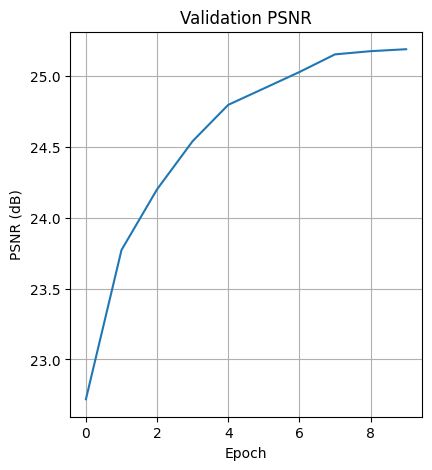

In [51]:
# Plot PSNR and SSIM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(val_psnr_values)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)



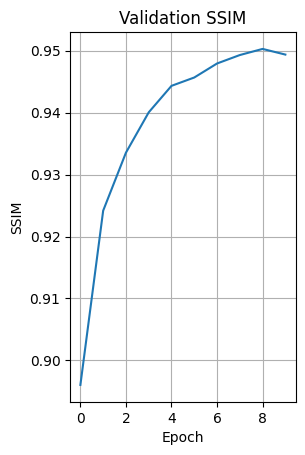

In [52]:
plt.subplot(1, 2, 2)
plt.plot(val_ssim_values)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)



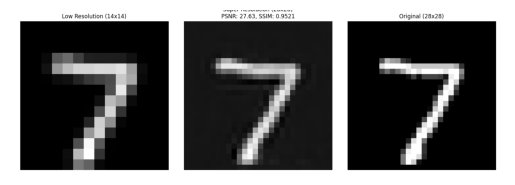

In [58]:
img_path = '/content/mnist_super_resolution/comparison_epoch10_img0.png'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

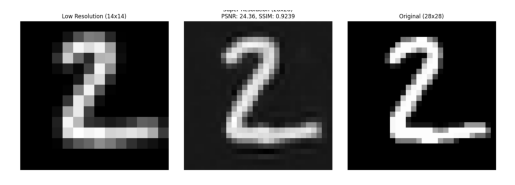

In [59]:
img_path = '/content/mnist_super_resolution/comparison_epoch10_img1.png'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [53]:

# Final evaluation on test set
model.load_state_dict(torch.load('./mnist_super_resolution/best_model.pth', weights_only=True))
model.eval()

test_psnr = []
test_ssim = []

with torch.no_grad():
    for lr, hr in tqdm(test_loader, desc="Evaluating Test Set"):
        lr, hr = lr.cuda(), hr.cuda()
        sr = model(lr)

        sr_np = sr[0].cpu().permute(1, 2, 0).numpy().squeeze()
        hr_np = hr[0].cpu().permute(1, 2, 0).numpy().squeeze()

        test_psnr.append(psnr(hr_np, sr_np, data_range=1.0))
        test_ssim.append(ssim(hr_np, sr_np, data_range=1.0))

print(f"Test Results - Average PSNR: {np.mean(test_psnr):.2f} dB, Average SSIM: {np.mean(test_ssim):.4f}")

Evaluating Test Set: 100%|██████████| 10000/10000 [01:09<00:00, 143.69it/s]

Test Results - Average PSNR: 25.19 dB, Average SSIM: 0.9471
